## Problem Statement 
Have you ever wondered how lenders use various factors such as credit score, annual income, the loan amount approved, tenure, debt-to-income ratio etc. and select your interest rates? 

The process, defined as ‘risk-based pricing’, uses a sophisticated algorithm that leverages different determining factors of a loan applicant. Selection of significant factors will help develop a prediction algorithm which can estimate loan interest rates based on clients’ information. On one hand, knowing the factors will help consumers and borrowers to increase their credit worthiness and place themselves in a better position to negotiate for getting a lower interest rate. On the other hand, this will help lending companies to get an immediate fixed interest rate estimation based on clients information. 


**Here, your goal is to use a training dataset to predict the loan rate category (1 / 2 / 3) that will be assigned to each loan in our test set.**

## Evaluation Metric
The evaluation metric for this competition is **Weighted F1 Score.**
<br>
 
For more information on the data and problem refer following link <br>
https://datahack.analyticsvidhya.com/contest/janatahack-machine-learning-for-banking/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [2]:
train_df = pd.read_csv("../input/jantahack/train_fNxu4vz.csv")
test_df = pd.read_csv("../input/jantahack/test_fjtUOL8.csv")
subm = pd.read_csv("../input/jantahack/sample_submission_HSqiq1Q.csv")

train = train_df.copy()
test = test_df.copy()

## Data Description

**Meaning of some variable for my reference**

* **Home_Owner** : - The home ownership status provided by the borrower during registration. Values are: Rent, Own, Mortgage, Other.

* **Income_Verified** : - Indicates if income was verified, not verified, or if the income source was verified

* **Purpose_Of_Loan** : - A category provided by the borrower for the loan request. 

* **Debt_To_Income** : - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested loan, divided by the borrower’s self-reported monthly income.

* **Inquiries_Last_6Mo** : -The number of inquiries by creditors during the past 6 months.

* **Months_Since_Deliquency** : -The number of months since the borrower's last delinquency.
Delinquency means that you are behind on payments. Once you are delinquent for a certain period of time (usually nine months for federal loans), your lender will declare the loan to be in default. The entire loan balance will become due at that time.



## Exploratory Data Analysis

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

In [4]:
## Checking for missing values in terms of percentage
(train_df.isnull().sum()/len(train_df))*100

Loan_ID                     0.000000
Loan_Amount_Requested       0.000000
Length_Employed             4.486060
Home_Owner                 15.427639
Annual_Income              15.277313
Income_Verified             0.000000
Purpose_Of_Loan             0.000000
Debt_To_Income              0.000000
Inquiries_Last_6Mo          0.000000
Months_Since_Deliquency    53.788289
Number_Open_Accounts        0.000000
Total_Accounts              0.000000
Gender                      0.000000
Interest_Rate               0.000000
dtype: float64

- Months_Since_Deliquency has almost 50% of missing data
- Home owner and annual income has 15% missing data and these features according to hypothesis are pretty important 

In [5]:
(test_df.isnull().sum()/len(train_df))*100

## Test Data also has same pattern for missing data

Loan_ID                     0.000000
Loan_Amount_Requested       0.000000
Length_Employed             3.004096
Home_Owner                 10.170471
Annual_Income              10.284281
Income_Verified             0.000000
Purpose_Of_Loan             0.000000
Debt_To_Income              0.000000
Inquiries_Last_6Mo          0.000000
Months_Since_Deliquency    35.822140
Number_Open_Accounts        0.000000
Total_Accounts              0.000000
Gender                      0.000000
dtype: float64

## We are not dealing with imbalalnce vo show kar using interest rate ka count

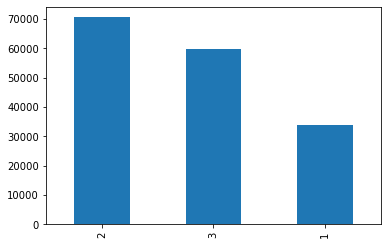

In [6]:
train_df["Interest_Rate"].value_counts().plot(kind="bar");

## Number of samples of all the three categories are not too far from one another i.e We are not dealing with imbalanced
## classification.

## Univariate Analysis

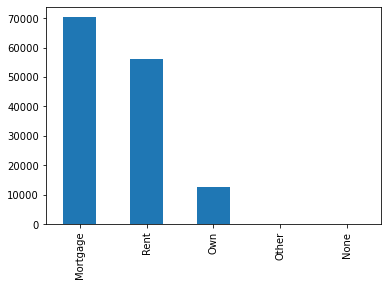

In [7]:
train_df["Home_Owner"].value_counts().plot(kind="bar");

### Inference
- Most of the applicants live on mortage 
- Very few applicants own their home
- Other and none should be combined as they are the same thing

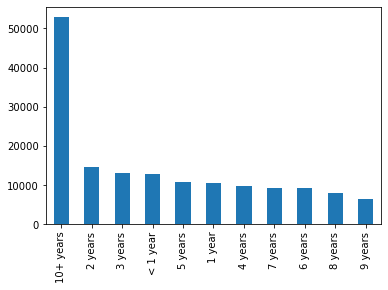

In [8]:
train_df["Length_Employed"].value_counts().plot(kind="bar");

# No specific trend binning them into two or three groups might be helpful

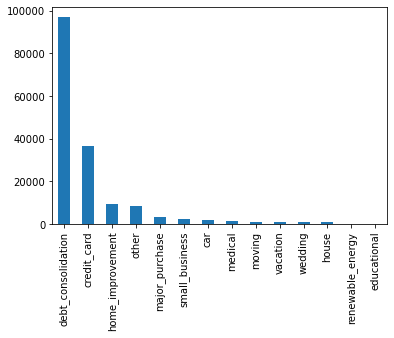

In [9]:
train_df["Purpose_Of_Loan"].value_counts().plot(kind="bar");

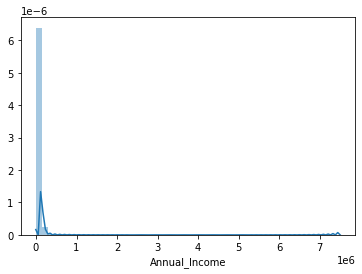

In [10]:
sns.distplot(train_df["Annual_Income"]);

# The data is highly skewed applying log transformation may work 

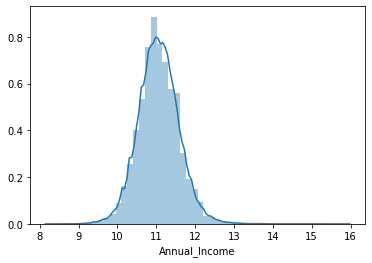

In [11]:
## Applying log transformation
sns.distplot(np.log(train_df["Annual_Income"]));

# This is better as it looks like Gaussian curve 

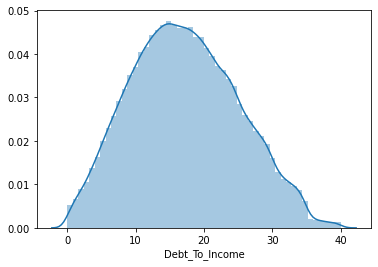

In [12]:
sns.distplot(train_df["Debt_To_Income"]);

# Most of the debt to income values lies betwwen 10 to 30

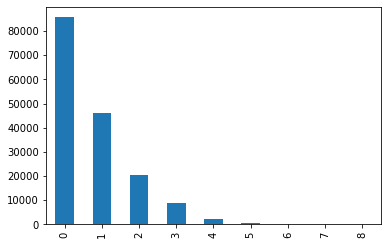

In [13]:
train_df["Inquiries_Last_6Mo"].value_counts().plot(kind="bar");

# Most applicant haven't even enquired about the loan
# Binning categories >4 into one will reduce categories

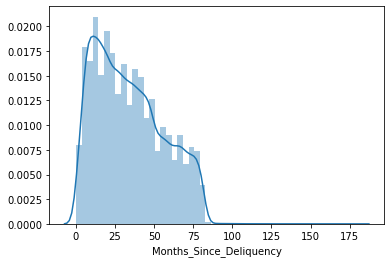

In [14]:
sns.distplot(train_df["Months_Since_Deliquency"]);

In [15]:
## Converting loan amt as numerical column
train_df["Loan_Amount_Requested"]= train_df["Loan_Amount_Requested"].str.replace('\D+','').astype(int)
test_df["Loan_Amount_Requested"]= test_df["Loan_Amount_Requested"].str.replace('\D+','').astype(int)

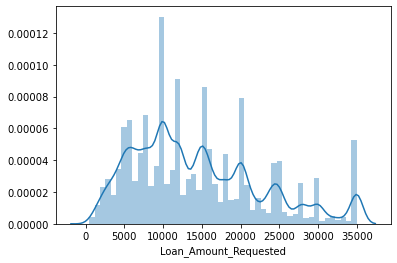

In [16]:
sns.distplot(train_df["Loan_Amount_Requested"]);

# Loan amount req has multiple peaks.I guess there might be some categories in
# which one can apply loan like between 10k to 20k which is inducing such pattern

## Bivariate Analysis

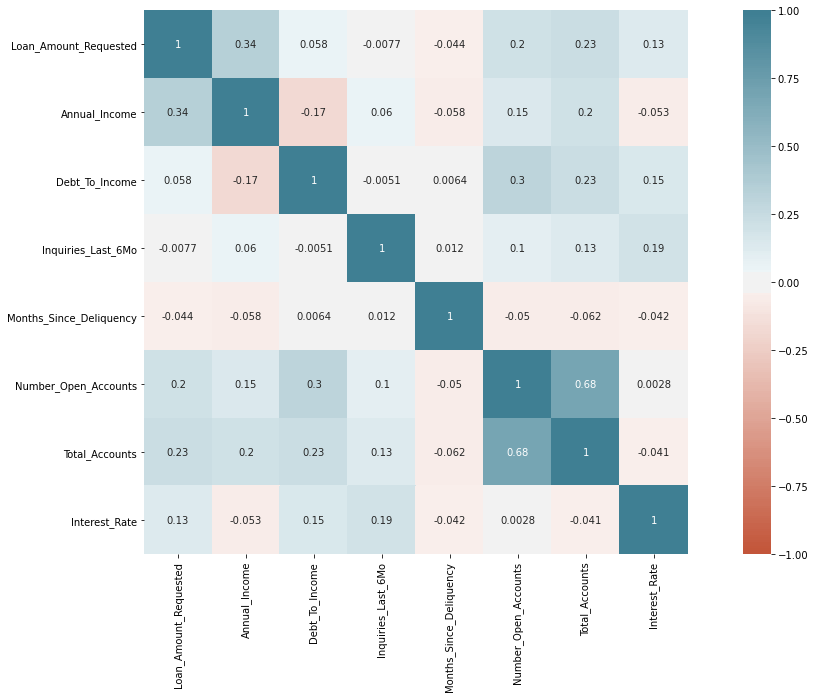

In [17]:
plt.figure(figsize=(20,10))
temp = train_df.drop("Loan_ID",axis=1)
corr = temp.corr()
sns.heatmap(corr,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True,annot=True);

## INFERENCE 
- LoanAmt requested and annual income  have a good positive correlation of 0.34 which makes sense as people will apply for  loan as much as they can pay.
- Total accounts and no of accounts are highly correlated which makes sense as no of accounts is one of the factor that contributes to total account. Hence reducing them to one particluar feature makes sense 
- LoanAmtRequested , DebttoIncome and Inquires since last 6 months have small positive corelation with InterestRate(category)

## Data Creation for training 

In [18]:
train = pd.read_csv("../input/jantahack/train_fNxu4vz.csv")
test = pd.read_csv("../input/jantahack/test_fjtUOL8.csv")
subm = pd.read_csv("../input/jantahack/sample_submission_HSqiq1Q.csv")


train_df = train.copy()
test_df = test.copy()


test_df["Interest_Rate"] = 21 # dummy value
# Joining train and test data as it will be easy to pre-process them once
joined_df = pd.concat([train_df,test_df],axis=0)
joined_df = joined_df.reset_index(drop=True)
print(f'Og Train shape {train_df.shape} \nOg Test Shape {test_df.shape} \nCombined Df {joined_df.shape}')


## Dropping loan id
joined_df.drop("Loan_ID",1,inplace=True)

## Coverting to int 
joined_df["Loan_Amount_Requested"]= joined_df["Loan_Amount_Requested"].str.replace('\D+','').astype(int)


## Because of  XGBOOST specifically since column names don't contains '<,>,]'
joined_df["Length_Employed"] = joined_df["Length_Employed"].replace(to_replace='10+ years',value="more_than_10yr")
joined_df["Length_Employed"] = joined_df["Length_Employed"].replace(to_replace='< 1 year',value="less_than_1yr")



## Numerical and cat cols
numerical = [col for col in joined_df.columns if joined_df[col].dtype!='object']
categorical = [col for col in joined_df.columns if joined_df[col].dtype =='object']
numerical.remove("Interest_Rate")


## Imuting missing values Using mode for categorical and median for numerical as it is more robust than mean
joined_df["Length_Employed"].fillna(joined_df["Length_Employed"].mode()[0],inplace=True)
joined_df["Home_Owner"].fillna(joined_df["Home_Owner"].mode()[0],inplace=True)
joined_df["Annual_Income"].fillna(joined_df["Annual_Income"].median(),inplace=True)
joined_df["Months_Since_Deliquency"].fillna(joined_df["Months_Since_Deliquency"].median(),inplace=True)



## Standard Scaling for numerical columns
scaler = StandardScaler()
numerical_data = pd.DataFrame(scaler.fit_transform(joined_df[numerical]))
numerical_data.columns = numerical


##  One Hot Encoding for categorical columns
joined_df = pd.concat([ 
            numerical_data,
            pd.get_dummies(joined_df['Length_Employed'],drop_first = True),
            pd.get_dummies(joined_df['Home_Owner'],drop_first = True),
            pd.get_dummies(joined_df['Income_Verified'],drop_first = True),
            pd.get_dummies(joined_df['Purpose_Of_Loan'],drop_first = True),
            pd.get_dummies(joined_df['Gender'],drop_first = True),
            joined_df["Interest_Rate"]
            
            ],axis=1)


## Let's separate train and test 

train_df = joined_df[:164309]
test_df = joined_df[164309:]

test_df.reset_index(drop=True,inplace=True) # since indexes were not starting from zero
test_df.drop(["Interest_Rate"],axis=1,inplace=True)
print(f'Final Train shape {train_df.shape} \nFinal Test Shape {test_df.shape}')


X_train,y_train = train_df.drop("Interest_Rate",1),train_df.loc[:,"Interest_Rate"]
print(f'Training shape {X_train.shape,y_train.shape}')

Og Train shape (164309, 14) 
Og Test Shape (109541, 14) 
Combined Df (273850, 14)
Final Train shape (164309, 38) 
Final Test Shape (109541, 37)
Training shape ((164309, 37), (164309,))


## Finding best Model
- Using cross_val_score to find which model is best suited for this task then further proceeding with that model

In [19]:
def cross_val_evaluate(model,X,y,cv,scoring,verbose,model_name):
    weighted_f1s = cross_val_score(model,X,y,cv=cv,scoring=scoring,verbose=verbose,n_jobs=-1)
    mean_weighted_f1 = round(np.sum(weighted_f1s)/cv,5)
    print(f" -----------------------{model_name}-------------------------------")
    print(f" weightedF1 for folds = {weighted_f1s}\n And Mean weighted_f1 on cv = {mean_weighted_f1}\n\n")

**Creating four fold cross_val_score whose evaluation metric is f1_weighted score as per the competition**

In [20]:
log = LogisticRegression()
cross_val_evaluate(log,X_train,y_train,4,"f1_weighted",4,"LOG")

knn = KNeighborsClassifier()
cross_val_evaluate(knn,X_train,y_train,4,"f1_weighted",4,"KNN")

gnb = GaussianNB()
cross_val_evaluate(gnb,X_train,y_train,4,"f1_weighted",4,"GNB")

dtc = DecisionTreeClassifier()
cross_val_evaluate(dtc,X_train,y_train,4,"f1_weighted",4,"DTC")

rfc = RandomForestClassifier()
cross_val_evaluate(rfc,X_train,y_train,4,"f1_weighted",4,"RFC")

xtc = ExtraTreesClassifier()
cross_val_evaluate(xtc,X_train,y_train,4,"f1_weighted",4,"XTC")

gbc = GradientBoostingClassifier()
cross_val_evaluate(gbc,X_train,y_train,4,"f1_weighted",4,"GBC")

xgb = XGBClassifier()
cross_val_evaluate(xgb,X_train,y_train,4,"f1_weighted",4,"XGB")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


 -----------------------LOG-------------------------------
 weightedF1 for folds = [0.48859631 0.48868228 0.48675941 0.48897445]
 And Mean weighted_f1 on cv = 0.48825




[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


 -----------------------KNN-------------------------------
 weightedF1 for folds = [0.44641557 0.44702437 0.45040984 0.44662246]
 And Mean weighted_f1 on cv = 0.44762




[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


 -----------------------GNB-------------------------------
 weightedF1 for folds = [0.40614576 0.39571309 0.40909762 0.31492677]
 And Mean weighted_f1 on cv = 0.38147




[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


 -----------------------DTC-------------------------------
 weightedF1 for folds = [0.43080463 0.42522437 0.42775338 0.42898777]
 And Mean weighted_f1 on cv = 0.42819




[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   52.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


 -----------------------RFC-------------------------------
 weightedF1 for folds = [0.50163831 0.50389411 0.50770104 0.50566217]
 And Mean weighted_f1 on cv = 0.50472




[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   54.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


 -----------------------XTC-------------------------------
 weightedF1 for folds = [0.48363605 0.48112076 0.48641619 0.48646701]
 And Mean weighted_f1 on cv = 0.48441




[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


 -----------------------GBC-------------------------------
 weightedF1 for folds = [0.51240197 0.51298493 0.51397785 0.51439362]
 And Mean weighted_f1 on cv = 0.51344


 -----------------------XGB-------------------------------
 weightedF1 for folds = [0.5316943  0.53164763 0.52968417 0.53065663]
 And Mean weighted_f1 on cv = 0.53092




[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.1min finished


## INFERENCE
- From all the above weighted f1 score it's obvious that XGBoost is better then rest of the classifier.Hence I proceeded with that model and performed feature engineering , hyper-paremeter tuning and different experimentations with it

## What didn't work 
**Created different preprocessed datasets and applied XGBoost model on them**
> a] Binned Dataset - wherein data binning preprocessing techniques were used along with PolynomialFeatures prepocessing with degree two. Model didn't show any sign of improvement instead weighted f1 score dropped .So I thought it would be due to humungous extra features which were created due to polynomial features total of 293 features columns were present (in one hot encoded format) which might be confusing model.
<br><br>
b] Then I picked top 100 features and iteratively reduced features from 100 to 60 then 50 till 40.Model showed slight improvement as features were reduced . So I decided not to use polynomial features instead going with normal features and create some new features.
<br><br>
c] Then I created new dataset where normal prerocessing techniques, as used above for creating training dataset were used and then I applied hyperparameter tuning to search for optimal hyperparameters .
<br><br>

## What worked 
>  Surprisingly the best pre-processing technique that worked for me was no pre-processing. The one wherein I didn't do any imputation for missing value , since XGBoost finds missing values on it's own using Sparsity-aware Split Finding algorithm . So I used dataset with no imputation .Then I found that some one hot encoded columns of categorical has very less values so I removed all those one hot encoded columns which had less that 5000  values .This pre-processed data along with the tuning parameters for XGBoost found from above point [c]  resulted in the best model which gave an f1-weighted score of 0.5344 and a rank of 84 among 8584 participants


**Implementation of what didn't work is in hyperparamter notebook**


## Implementation of what worked 

In [21]:
## Data Creation

train = pd.read_csv("../input/jantahack/train_fNxu4vz.csv")
test = pd.read_csv("../input/jantahack/test_fjtUOL8.csv")
subm = pd.read_csv("../input/jantahack/sample_submission_HSqiq1Q.csv")


train_df = train.copy()
test_df = test.copy()


test_df["Interest_Rate"] = 21 # dummy value
# Joining train and test data as it will be easy to pre-process them once
joined_df = pd.concat([train_df,test_df],axis=0)
joined_df = joined_df.reset_index(drop=True)
print(f'Og Train shape {train_df.shape} \nOg Test Shape {test_df.shape} \nCombined Df {joined_df.shape}')


## Dropping loan id
joined_df.drop("Loan_ID",1,inplace=True)
print(f'Shape after dropping loan id {joined_df.shape}')

## Coverting to int 
joined_df["Loan_Amount_Requested"]= joined_df["Loan_Amount_Requested"].str.replace('\D+','').astype(int)


## Because of  XGBOOST specifically since column names don't contains '<,>,]'
joined_df["Length_Employed"] = joined_df["Length_Employed"].replace(to_replace='10+ years',value="more_than_10yr")
joined_df["Length_Employed"] = joined_df["Length_Employed"].replace(to_replace='< 1 year',value="less_than_1yr")




Og Train shape (164309, 14) 
Og Test Shape (109541, 14) 
Combined Df (273850, 14)
Shape after dropping loan id (273850, 13)


## Feature Engineering
- This time I won't do any kind of imputation 
- I created few features which I thought might be useful

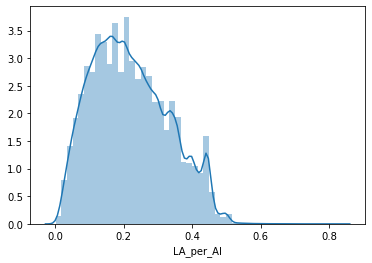

In [22]:
## What is the loan amount w.r.t Loan amount requested by applicant ?

joined_df["LA_per_AI"] = np.round(joined_df["Loan_Amount_Requested"]/joined_df["Annual_Income"],4)
sns.distplot(joined_df["LA_per_AI"]);

# I thought the loan amount requested by an applicant w.r.t his/her annual income might be a useful ratio 
# to decide in which category of Interest rate an applicant falls.

# Because the smaller this ratio would be less time an applicant will need to repay the amount and vice versa .
# Hence charge interest rate accordingly  

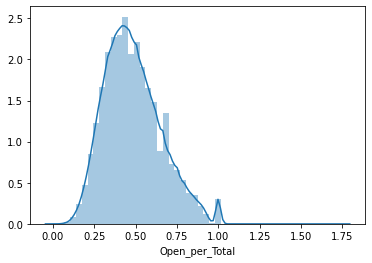

In [23]:
##  creating no of close account
joined_df["no_close_accnts"] = joined_df["Total_Accounts"]-joined_df["Number_Open_Accounts"]

# How many total accounts does an applicant have w.r.t total accounts conveys a message that does this person has more
# closed account then open which is not a good sign for the banks.Because the more credit score , the more payment history
# and reliabilty is better when applying loans to decide interest rate
joined_df["Open_per_Total"] = round(joined_df["Number_Open_Accounts"]/joined_df["Total_Accounts"],4)

# Looking at the distribution of data
sns.distplot(joined_df["Open_per_Total"]);

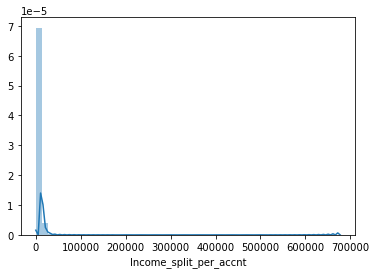

In [24]:
## Income_split_per_accnt communicates amount an applicant can split into his various accounts .
## Eg if this value is very small then it conveys that this person has more accounts w.r.t his income which is not a good sign

joined_df["Income_split_per_accnt"] = round(joined_df["Annual_Income"]/(joined_df["Number_Open_Accounts"]+1),4)
sns.distplot(joined_df["Income_split_per_accnt"]);


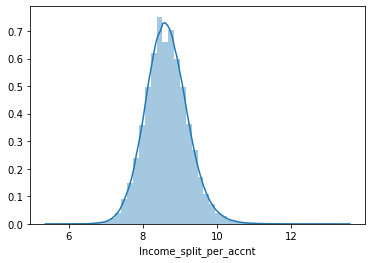

In [25]:
# The data looks quite skewed hence taking log.
joined_df["Income_split_per_accnt"] = np.log(joined_df["Income_split_per_accnt"])
sns.distplot(joined_df["Income_split_per_accnt"]);

# This looks more like gaussian curve 

**These were the few features which I created revolving around Loan Amt , Annual income and Number of Accounts as per my research from online and my intuition**

## Data Creation

In [26]:
## Standard Scaling for numerical columns

## Numerical and cat cols
numerical = [col for col in joined_df.columns if joined_df[col].dtype!='object']
categorical = [col for col in joined_df.columns if joined_df[col].dtype =='object']
numerical.remove("Interest_Rate")

scaler = StandardScaler()
numerical_data = pd.DataFrame(scaler.fit_transform(joined_df[numerical]))
numerical_data.columns = numerical


##  One Hot Encoding for categorical columns
joined_df = pd.concat([ 
            numerical_data,
            pd.get_dummies(joined_df['Length_Employed'],drop_first = True),
            pd.get_dummies(joined_df['Home_Owner'],drop_first = True),
            pd.get_dummies(joined_df['Income_Verified'],drop_first = True),
            pd.get_dummies(joined_df['Purpose_Of_Loan'],drop_first = True),
            pd.get_dummies(joined_df['Gender'],drop_first = True),
            joined_df["Interest_Rate"]
            
            ],axis=1)


## Let's separate train and test 

train_df = joined_df[:164309]
test_df = joined_df[164309:]

test_df.reset_index(drop=True,inplace=True) # since indexes were not starting from zero
test_df.drop(["Interest_Rate"],axis=1,inplace=True)
print(f'Final Train shape {train_df.shape} \nFinal Test Shape {test_df.shape}')


Final Train shape (164309, 42) 
Final Test Shape (109541, 41)


**Removing those one hot encoded columns which has very liitle data**
- I tried different thresholds for removing but 5000 was the one which gave best result

In [27]:
## Creating a list of categorical columns which 

columns = train["Purpose_Of_Loan"].value_counts().index.tolist()+train["Length_Employed"].value_counts().index.tolist()
columns.extend(["more_than_10yr","less_than_1yr"])
columns.remove('10+ years')
columns.remove('< 1 year')
print(*columns,sep=", ")

debt_consolidation, credit_card, home_improvement, other, major_purchase, small_business, car, medical, moving, vacation, wedding, house, renewable_energy, educational, 2 years, 3 years, 5 years, 1 year, 4 years, 7 years, 6 years, 8 years, 9 years, more_than_10yr, less_than_1yr


In [28]:
print(f'Originally shape of train = {train_df.shape} and shape of test = {test_df.shape}')
for col in columns:
    if col in train_df.columns.to_list() and train_df[col].value_counts()[1] < 5000:
        train_df.drop(col,1,inplace=True)
        test_df.drop(col,1,inplace=True)
        
print(f'After shape of train = {train_df.shape} and shape of test = {test_df.shape}')

Originally shape of train = (164309, 42) and shape of test = (109541, 41)
After shape of train = (164309, 33) and shape of test = (109541, 32)


In [29]:
X_train,y_train = train_df.drop("Interest_Rate",1),train_df.loc[:,"Interest_Rate"]
print(f'Training shape {X_train.shape,y_train.shape}')

xgb = XGBClassifier(
                learning_rate=0.2,
                n_estimators=150,
                subsample=1,
                colsample_bytree=1,
                objective='multi:softprob', 
                n_jobs=-1,
                scale_pos_weight=None, 
                verbosity=3,
                max_depth=6,
                min_child_weight =14,
                gamma = 0.3
               )


Training shape ((164309, 32), (164309,))


In [32]:
xgb.fit(X_train,y_train)
preds = xgb.predict(test_df)
subm["Interest_Rate"] = preds
subm.to_csv("./xgb.csv",index=False)

## Feature Importance 

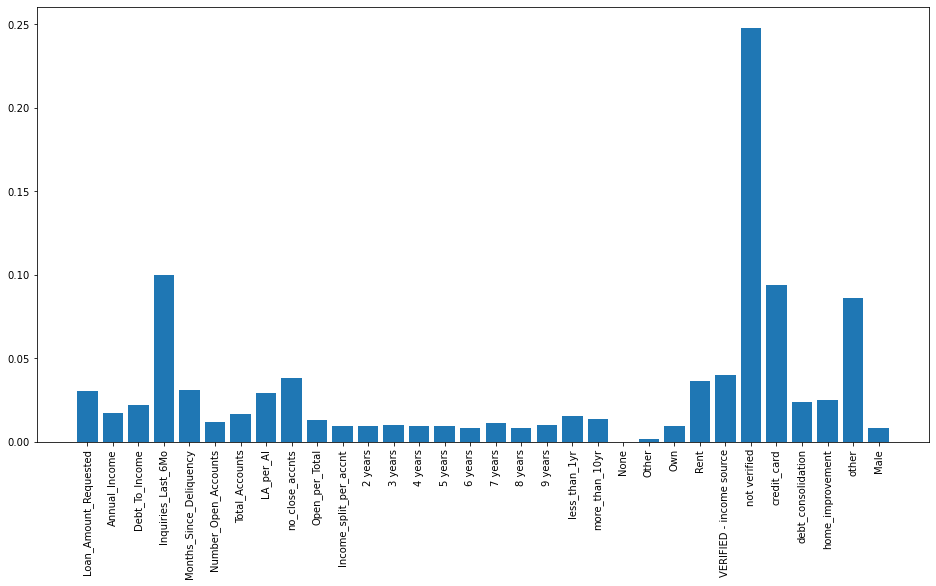

In [33]:
plt.figure(figsize=(16,8))
plt.bar(X_train.columns.to_list(), xgb.feature_importances_);
plt.xticks(rotation=90);

## Inference
- Applicants income source has greatest feature importance as per our model which definitely holds in real life.No bank would provide loan under a reasonable interest rate to an applicant whose income sources are not verified .
- Categories under the purpose of loan features also have the next greater importance as per our XGBoost model.Surprisingly the other catgory of purpose_of_loan has pretty good importance which in real life would be due to the ambiguity of that category .
- Categories under Length_of_Employment has more or less same importance except if someone has less than 1 yr of employment status , which makes sense as they are little less reliable
- Inquires_since_last_6_months also has pretty good weight as it conveys how much an applicant is in need of that loan and Hence bank can negotiate the Interest rate as per the urgency and needs of the applicant